# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO, BytesIO
from matplotlib import pyplot as plt
from PIL import Image

import pandas as pd
import pickle
import time

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util

# Model preparation 

In [4]:
PATH_TO_CKPT = 'output_dir/frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [5]:
PATH_TO_LABELS = 'data/tl_label_map.pbtxt'
NUM_CLASSES = 3
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [6]:
categories

[{'id': 1, 'name': 'Red'},
 {'id': 2, 'name': 'Yellow'},
 {'id': 3, 'name': 'Green'}]

## Helper code

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
PATH_TO_TEST_IMAGES_DIR = 'images_uniform'
names = ['a.png' , 
         'site_1507478129.999281883.png', 'site_1507478131.826476097.png', 'site_1507478133.23868083.png', 
         'raw_1507416001.png', 'raw_1507417424.png', 'sim_1507476862.png', 'sim_1507476577.png', 
         'red5.png', 'green3.png', 'yellow1.png']

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, i) for i in names ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

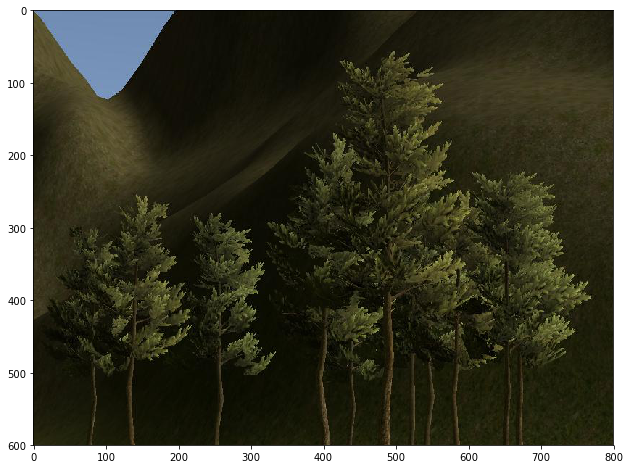

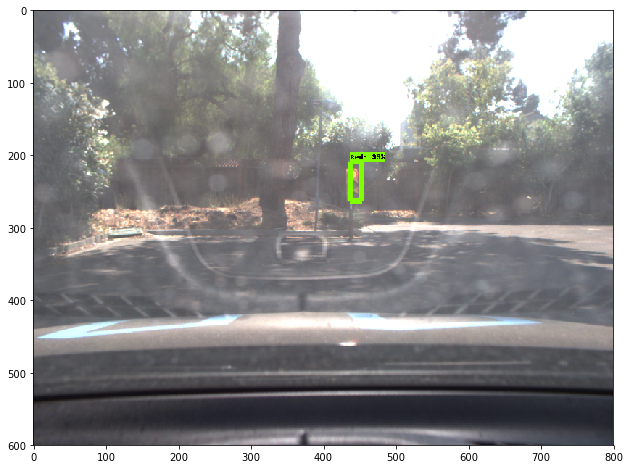

Red 0.998823
Distance (metres) 8.0
Time in milliseconds 61.231136322021484
Raw scores [ 0.99882287  0.03270873  0.00946345  0.00619944] 



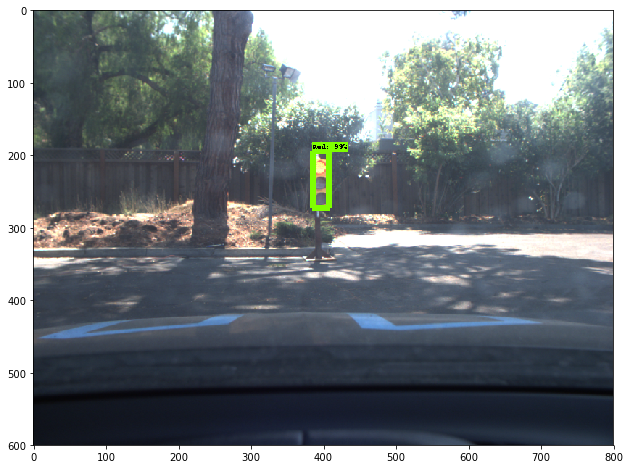

Red 0.99944
Distance (metres) 6.0
Time in milliseconds 62.870025634765625
Raw scores [ 0.99943978  0.16488807  0.01438077  0.00659332] 



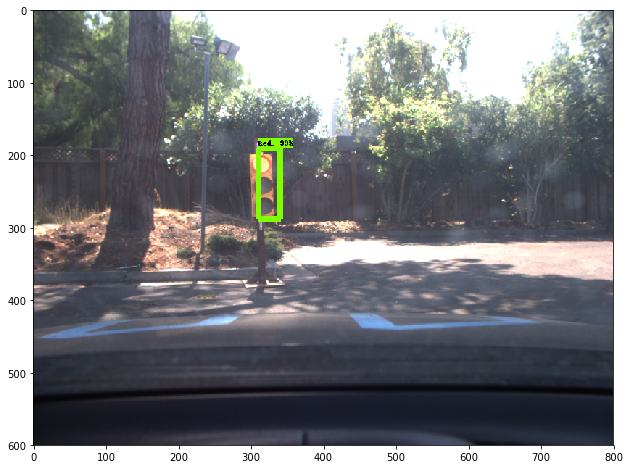

Red 0.998848
Distance (metres) 4.0
Time in milliseconds 62.98708915710449
Raw scores [ 0.99884844  0.04248678  0.02373972  0.00939899] 



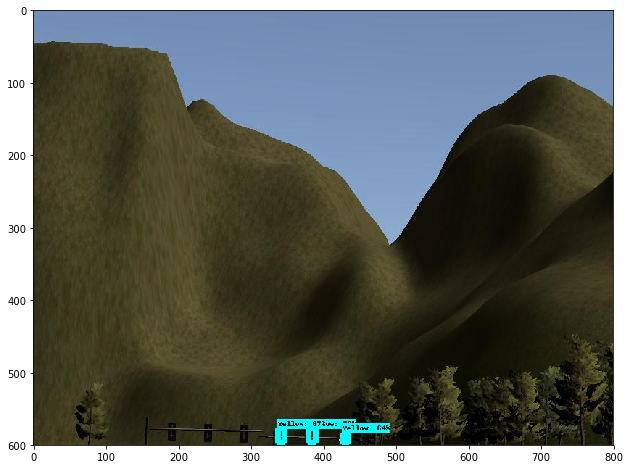

Yellow 0.794936
Time in milliseconds 61.94782257080078
Raw scores [ 0.794936    0.67811048  0.64793789  0.32792366] 

Yellow 0.67811
Time in milliseconds 61.94782257080078
Raw scores [ 0.794936    0.67811048  0.64793789  0.32792366] 

Yellow 0.647938
Time in milliseconds 61.94782257080078
Raw scores [ 0.794936    0.67811048  0.64793789  0.32792366] 



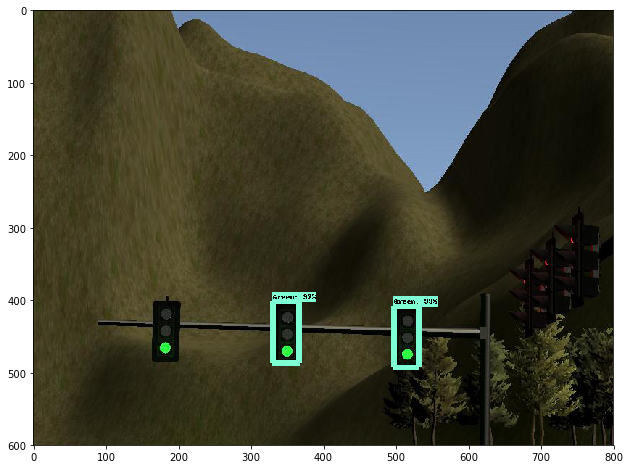

Green 0.997259
Time in milliseconds 62.567949295043945
Raw scores [ 0.99725938  0.97807342  0.49007294  0.04162833] 

Green 0.978073
Time in milliseconds 62.567949295043945
Raw scores [ 0.99725938  0.97807342  0.49007294  0.04162833] 



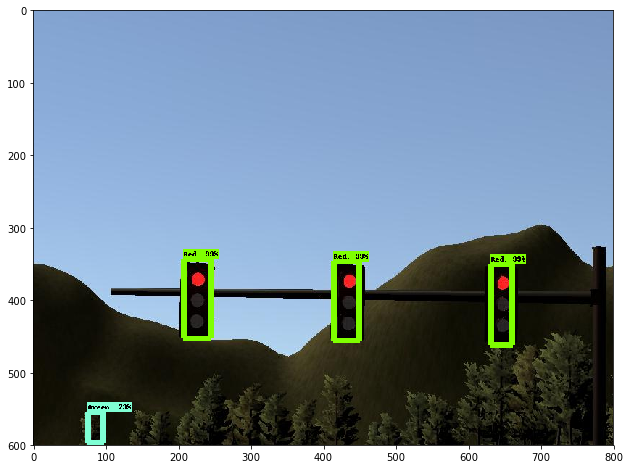

Red 0.998037
Time in milliseconds 72.9069709777832
Raw scores [ 0.9980368   0.99702555  0.99662042  0.73630327] 

Red 0.997026
Time in milliseconds 72.9069709777832
Raw scores [ 0.9980368   0.99702555  0.99662042  0.73630327] 

Red 0.99662
Time in milliseconds 72.9069709777832
Raw scores [ 0.9980368   0.99702555  0.99662042  0.73630327] 

Green 0.736303
Time in milliseconds 72.9069709777832
Raw scores [ 0.9980368   0.99702555  0.99662042  0.73630327] 



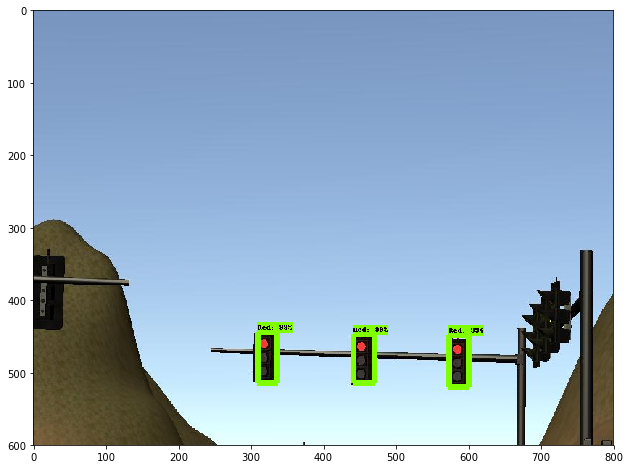

Red 0.9996
Time in milliseconds 63.825130462646484
Raw scores [ 0.99959964  0.99887496  0.99854904  0.0132636 ] 

Red 0.998875
Time in milliseconds 63.825130462646484
Raw scores [ 0.99959964  0.99887496  0.99854904  0.0132636 ] 

Red 0.998549
Time in milliseconds 63.825130462646484
Raw scores [ 0.99959964  0.99887496  0.99854904  0.0132636 ] 



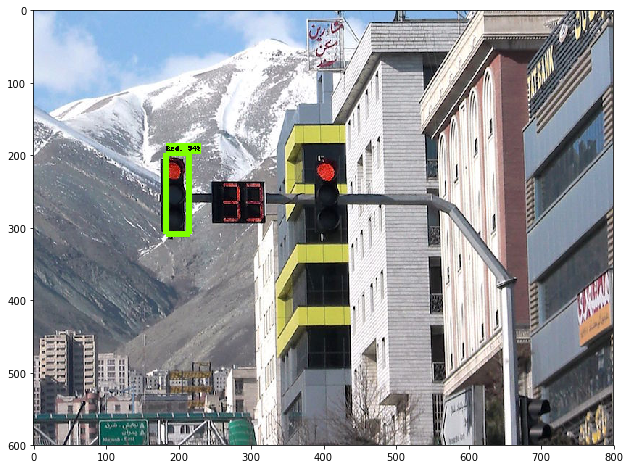

Red 0.948222
Time in milliseconds 61.23518943786621
Raw scores [ 0.9482221   0.27801937  0.09550884  0.0126824 ] 



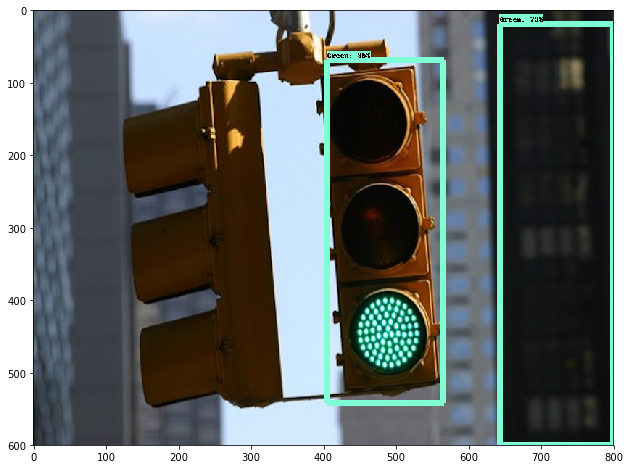

Green 0.958466
Time in milliseconds 62.355995178222656
Raw scores [ 0.95846552  0.79483545  0.25407025  0.14222102] 

Green 0.794835
Time in milliseconds 62.355995178222656
Raw scores [ 0.95846552  0.79483545  0.25407025  0.14222102] 



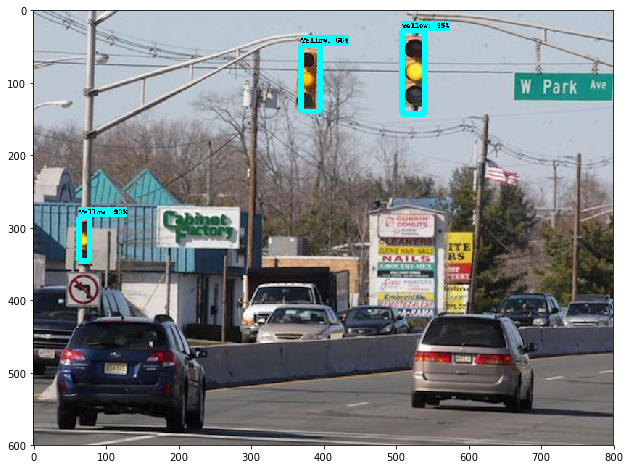

Yellow 0.950645
Time in milliseconds 65.41061401367188
Raw scores [ 0.95064527  0.93918365  0.66725773  0.40880191] 

Yellow 0.939184
Time in milliseconds 65.41061401367188
Raw scores [ 0.95064527  0.93918365  0.66725773  0.40880191] 

Yellow 0.667258
Time in milliseconds 65.41061401367188
Raw scores [ 0.95064527  0.93918365  0.66725773  0.40880191] 



In [9]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            time0 = time.time()
            
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
            time1 = time.time()
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            min_score_thresh = .50
            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            for i in range(boxes.shape[0]):
                if scores[i] > min_score_thresh:
                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  1345.200806
                    fy =  1353.838257
                    
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600
                    
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )
                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    if image_path.find('site') > -1: print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000)
                    print("Raw scores", scores, "\n")